<a href="https://colab.research.google.com/github/ariG23498/NeuralStyleTransfer/blob/master/GradientTapeExp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
import cv2
from tqdm import tqdm

In [2]:
print('tf Version: {}'.format(tf.__version__))
print('Executing eagerly: {}'.format(tf.executing_eagerly()))

tf Version: 2.3.0
Executing eagerly: True


# Dataset

In [3]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 35.35 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [4]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [5]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [6]:
X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)

  8%|▊         | 20/250 [00:00<00:01, 192.63it/s]

(1250, 224, 224, 3) (1250,)


100%|██████████| 250/250 [00:01<00:00, 171.34it/s]


(250, 224, 224, 3) (250,)


# Pretrained VGG16

In [ ]:
model = tf.keras.applications.VGG16()
model.summary()

# Layers of the model

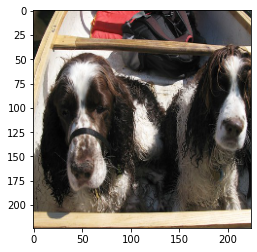

In [8]:
# the layers that I want to tap
layers = [
          'block5_pool',
          'block4_pool',
          'block3_pool',
          'block2_pool',
          'block1_pool'
]
# The input of choice
X = tf.constant(X_train[np.newaxis,0,:,:,:])
plt.imshow(X[0])

In [10]:
# the models created
models = list()
# images created
white_images = list()
# outputs created
output_images = list()
# loss created
losses = list()

for layer in layers:
  m = tf.keras.Model(
      inputs=model.input,
      outputs=model.get_layer(layer).output
      )
  models.append(m)

  white_images.append(
      tf.Variable(tf.ones(shape=(1,224,224,3)))
      )
  
  losses.append(
      list()
      )
  
  output_images.append(
      m(X)
  )

In [11]:
def train_step(anchor, white, slice_model, loss_history):
  with tf.GradientTape() as tape:
    output_white_image = slice_model(white)
    loss = loss_fun(anchor, output_white_image)

  loss_history.append(loss.numpy().mean())
  grads = tape.gradient(loss, [white])
  optimizer.apply_gradients(
      zip(grads, [white])
      )

# Iterate and watch

In [14]:
optimizer = tf.keras.optimizers.Adam()
loss_fun = tf.keras.losses.MSE
for idx,layer in enumerate(layers):
  print("For {} layer. Name {}".format(idx, layer))
  for i in tqdm(range(100)):
    train_step(output_images[idx], white_images[idx], models[idx], losses[idx])

  0%|          | 0/100 [00:00<?, ?it/s]

For 0 layer. Name block5_pool


  0%|          | 0/100 [00:00<?, ?it/s]

For 1 layer. Name block4_pool


  0%|          | 0/100 [00:00<?, ?it/s]

For 2 layer. Name block3_pool


  0%|          | 0/100 [00:00<?, ?it/s]

For 3 layer. Name block2_pool


  0%|          | 0/100 [00:00<?, ?it/s]

For 4 layer. Name block1_pool


100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


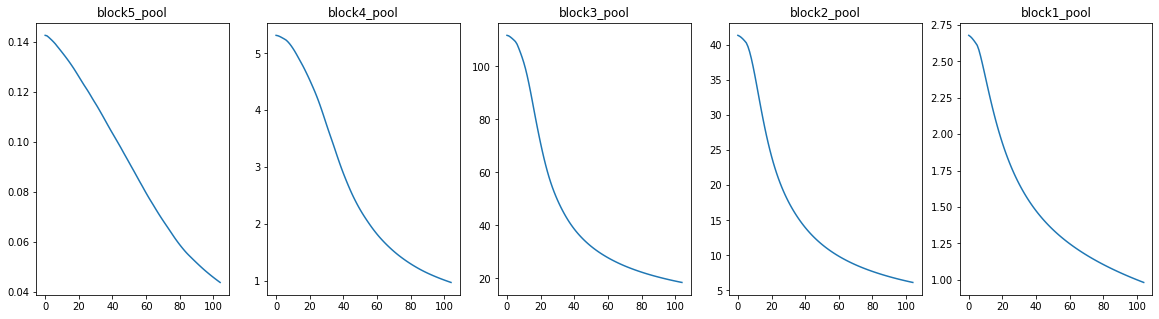

In [20]:
plt.figure(figsize=(20,5))
for idx,loss in enumerate(losses):
  plt.subplot(1,5,idx+1)
  plt.plot(loss) 
  plt.title(layers[idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


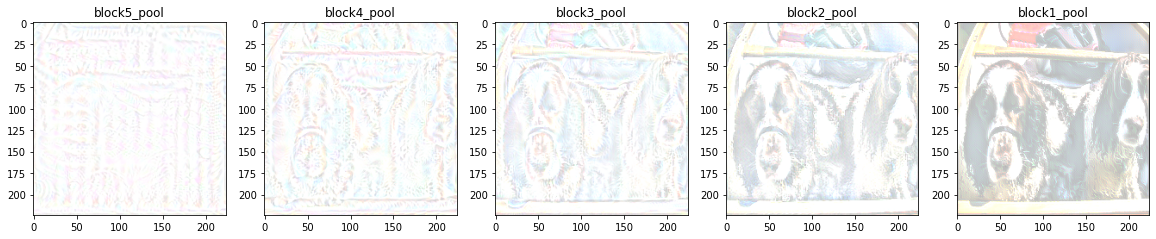

In [21]:
plt.figure(figsize=(20,5))
for idx,image in enumerate(white_images):
  plt.subplot(1,5,idx+1)
  plt.imshow(image[0])
  plt.title(layers[idx])